Hunter Bennett | Kupffer Strains | Glass Lab | 03 May 2021

Goal is to make heatmap of selected motif for epigenetic diversity figure in NASH paper.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
atacDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

### Make directory for heatmap

In [4]:
if not os.path.isdir('./atac_known_motif_heatmap/'):
    os.mkdir('./atac_known_motif_heatmap/')

# Aggregate results - Homer

In [11]:
known_motif_pval_frame = pd.read_csv(atacDirectory+'/homer_known_motifs_differential_log.txt', sep='\t', index_col=0)

In [12]:
known_motif_pval_frame.head()

,aj_intersection_distal_motifs,aj_intersection_distal_motifs_nobg_nodenovo,aj_intersection_motifs,aj_intersection_motifs_nobg_nodenovo,aj_union_distal_motifs,aj_union_distal_motifs_nobg_nodenovo,aj_union_motifs,aj_union_motifs_nobg_nodenovo,balbcj_intersection_distal_motifs,balbcj_intersection_distal_motifs_nobg_nodenovo,...,balbcj_union_motifs,balbcj_union_motifs_nobg_nodenovo,c57bl6j_intersection_distal_motifs,c57bl6j_intersection_distal_motifs_nobg_nodenovo,c57bl6j_intersection_motifs,c57bl6j_intersection_motifs_nobg_nodenovo,c57bl6j_union_distal_motifs,c57bl6j_union_distal_motifs_nobg_nodenovo,c57bl6j_union_motifs,c57bl6j_union_motifs_nobg_nodenovo
ELF5(ETS)/T47D-ELF5-ChIP-Seq(GSE30407)/Homer,-1.7770,-130.50,-2.4280,-146.20,-0.25480,-784.3,-1.3160,-897.6,-0.23630,-167.0,...,-4.673,-1328.0,-5.9230,-382.5,-5.4850,-452.0,-2.730000,-970.8,-2.108000,-1149.0
Elf4(ETS)/BMDM-Elf4-ChIP-Seq(GSE88699)/Homer,-0.5045,-111.10,-0.5638,-126.80,-0.07368,-781.7,-0.3825,-891.7,-0.11370,-164.7,...,-3.179,-1381.0,-2.2270,-355.4,-1.9600,-413.8,-0.938800,-968.3,-0.347100,-1098.0
PU.1(ETS)/ThioMac-PU.1-ChIP-Seq(GSE21512)/Homer,-0.7784,-121.20,-0.7527,-124.90,-0.39930,-823.7,-0.7574,-868.6,-0.07585,-149.2,...,-2.936,-1384.0,-0.3812,-303.4,-0.3493,-350.5,-0.003808,-841.5,-0.002021,-965.9
ELF3(ETS)/PDAC-ELF3-ChIP-Seq(GSE64557)/Homer,-1.2620,-99.81,-1.1500,-105.20,-0.01860,-562.8,-0.1233,-636.2,-0.06488,-116.4,...,-3.844,-1060.0,-4.3630,-293.7,-4.4590,-341.3,-3.664000,-792.0,-3.337000,-925.6
ETS1(ETS)/Jurkat-ETS1-ChIP-Seq(GSE17954)/Homer,-0.5172,-82.25,-0.3737,-89.27,-0.23360,-601.8,-0.4874,-643.1,-0.58690,-135.4,...,-9.330,-1060.0,-3.1520,-276.6,-2.8450,-318.7,-1.803000,-733.6,-0.904700,-837.5


# Plot known motif results

## Option for future: set custom motif list

In [13]:
known_motif_pval_frame.columns

Index(['aj_intersection_distal_motifs',
       'aj_intersection_distal_motifs_nobg_nodenovo', 'aj_intersection_motifs',
       'aj_intersection_motifs_nobg_nodenovo', 'aj_union_distal_motifs',
       'aj_union_distal_motifs_nobg_nodenovo', 'aj_union_motifs',
       'aj_union_motifs_nobg_nodenovo', 'balbcj_intersection_distal_motifs',
       'balbcj_intersection_distal_motifs_nobg_nodenovo',
       'balbcj_intersection_motifs',
       'balbcj_intersection_motifs_nobg_nodenovo',
       'balbcj_union_distal_motifs',
       'balbcj_union_distal_motifs_nobg_nodenovo', 'balbcj_union_motifs',
       'balbcj_union_motifs_nobg_nodenovo',
       'c57bl6j_intersection_distal_motifs',
       'c57bl6j_intersection_distal_motifs_nobg_nodenovo',
       'c57bl6j_intersection_motifs',
       'c57bl6j_intersection_motifs_nobg_nodenovo',
       'c57bl6j_union_distal_motifs',
       'c57bl6j_union_distal_motifs_nobg_nodenovo', 'c57bl6j_union_motifs',
       'c57bl6j_union_motifs_nobg_nodenovo'],
      dty

In [14]:
motif_list = ['Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer',
              'MITF(bHLH)/MastCells-MITF-ChIP-Seq(GSE48085)/Homer',
              'IRF2(IRF)/Erythroblas-IRF2-ChIP-Seq(GSE36985)/Homer',
              'Mef2d(MADS)/Retina-Mef2d-ChIP-Seq(GSE61391)/Homer',
              'ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer',
              'NFkB-p65(RHD)/GM12787-p65-ChIP-Seq(GSE19485)/Homer',
              'Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)/Homer']

# we will make this plot using 'union' differential enhancer set
# we will also use all enhancers to raise our power.

tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('nobg_nodenovo')]

tmp_frame = tmp_frame.loc[motif_list, :]

#clean up rows for tmp frame
tmp_frame.index = tmp_frame.index.str.split('/').str[0].str.split('(').str[0].str.upper()

# convert to log10 p value
tmp_frame = np.log10(np.e**(tmp_frame))

# clean up columns
tmp_frame.columns = ['A/J', 'BALB/cJ', 'C57BL/6J']

In [15]:
mm_conv = 25.4

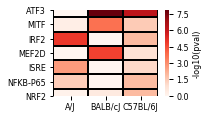

In [16]:
# set plot size
fig, ax = plt.subplots(figsize=(60/mm_conv, 40/mm_conv))

# convert to a log2 frame
tmp_frame = np.log10(np.e**(tmp_frame))

cm = sns.heatmap(
    -tmp_frame,
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    # annot=True,
    cbar_kws={'label': '-log10(pval)'})
    #square=True)

plt.savefig('./atac_known_motif_heatmap/homer_enrichedmotifs_custommotifs_intersection_enhancers.pdf',
            bbox_inches='tight')

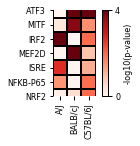

In [18]:
# set plot size
fig, ax = plt.subplots(figsize=(60/mm_conv, 40/mm_conv))

cm = sns.heatmap(
    -tmp_frame,
    cmap='Reds',
    linewidths=1,
    linecolor='black',
    cbar=False,
    vmin=0,
    vmax=4,
    # annot=True,
    #cbar_kws={'label': '-log10(pval)'},
    square=True)

# colorbar
cmap = matplotlib.cm.Reds
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  ax=ax,
                  orientation='vertical',
                  ticks=[0,4],
                  label='-log10(p-value)',
                  use_gridspec=True,
                  shrink=1,
                  pad=0.05,
                  fraction=0.05,
                  aspect=15
                  )

plt.savefig('./atac_known_motif_heatmap/homer_enrichedmotifs_custommotifs_intersection_enhancers_square.pdf',
            bbox_inches='tight')

In [19]:
motif_list = ['Atf3(bZIP)/GBM-ATF3-ChIP-Seq(GSE33912)/Homer',
              'MITF(bHLH)/MastCells-MITF-ChIP-Seq(GSE48085)/Homer',
              'IRF2(IRF)/Erythroblas-IRF2-ChIP-Seq(GSE36985)/Homer',
              'Mef2d(MADS)/Retina-Mef2d-ChIP-Seq(GSE61391)/Homer',
              'ISRE(IRF)/ThioMac-LPS-Expression(GSE23622)/Homer',
              'NFkB-p65(RHD)/GM12787-p65-ChIP-Seq(GSE19485)/Homer',
              'Nrf2(bZIP)/Lymphoblast-Nrf2-ChIP-Seq(GSE37589)/Homer']

# we will make this plot using 'union' differential enhancer set
# we will also use all enhancers to raise our power.

tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('distal')]
tmp_frame = tmp_frame.loc[:, ~tmp_frame.columns.str.contains('nobg_nodenovo')]

tmp_frame = tmp_frame.loc[motif_list, :]

#clean up rows for tmp frame
tmp_frame.index = tmp_frame.index.str.split('/').str[0].str.split('(').str[0].str.upper()

# convert to log10 p value
tmp_frame = np.log10(np.e**(tmp_frame))

# clean up columns
tmp_frame.columns = ['A/J', 'BALB/cJ', 'C57BL/6J']

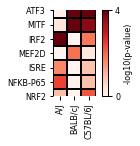

In [20]:
# set plot size
fig, ax = plt.subplots(figsize=(60/mm_conv, 40/mm_conv))

cm = sns.heatmap(
    -tmp_frame,
    cmap='Reds',
    linewidths=1,
    linecolor='black',
    cbar=False,
    vmin=0,
    vmax=4,
    # annot=True,
    #cbar_kws={'label': '-log10(pval)'},
    square=True)

# colorbar
cmap = matplotlib.cm.Reds
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm,  cmap=cmap),
                  ax=ax,
                  orientation='vertical',
                  ticks=[0,4],
                  label='-log10(p-value)',
                  use_gridspec=True,
                  shrink=1,
                  pad=0.05,
                  fraction=0.05,
                  aspect=15
                  )